## Imports

In [82]:
# offizielle libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# selbstgeschrieben
import file_organizer as fo
from func import get_norm_cm
from func import ticks_handle

## FID

In [84]:
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "J")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove('time')

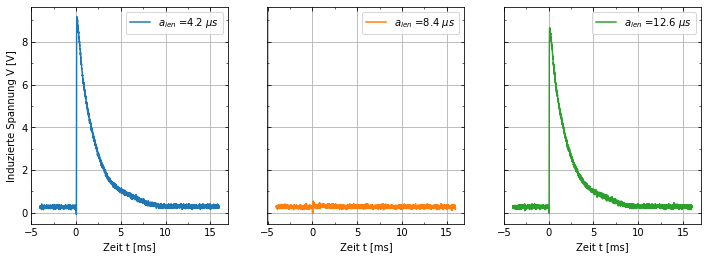

In [86]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
fig, axs = plt.subplots(1,3,figsize=(12,4), sharey=True)

for i in range(3):
    data.plot(x='time',y=labels[i], ax=axs[i], color=colors[i], label=f'$a_{{len}}$ ={selection[i].A} $\\mu s$')
    axs[i].set_xlabel("Zeit t [ms]")
    axs[i].set_ylabel("Induzierte Spannung V [V]")
    axs[i].grid()
    ticks_handle(axs[i], which='both')
fig.savefig('IMAGES/lmo_fid.png')

## T1 aus Periode

Daten von Tag 1
> path = 'data_day_one'; 
> meas = E

zu kleine Zeiten P

Daten von Tag 2
> path = 'data_day_two', meas = K;

In [87]:
# Neuer Versuch
path = "data_day_two"
file_list = fo.load_file_list(path)
selection = fo.select_files(file_list, "meas", "K")
data = fo.load_files(selection)
data = fo.df_combine(data)
del data["iout"]
data["time"] = data["time"] * 1000
labels = list(data.columns)
labels.remove("time")
P = [meas.P for meas in selection]
M = [data[l].max() for l in labels]

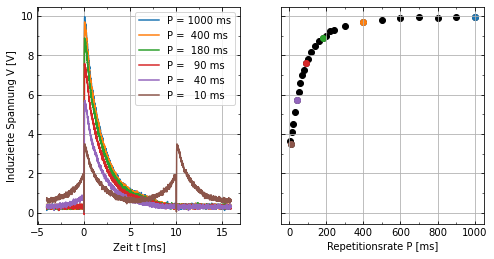

In [88]:
split=False
if not split:
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
else:
    fig1, (ax) = plt.subplots(figsize=(4, 4))
    fig2, (bx) = plt.subplots(figsize=(4, 4))

inds = [0, 6, 11, 16, 21, 25]
data.plot(x="time",y=[labels[i] for i in inds], ax=ax,
          label=[f'P = {P[i]:4.0f} ms' for i in inds])
ax.set_xlabel("Zeit t [ms]")
ax.set_ylabel("Induzierte Spannung V [V]")
ax.legend()

bx.scatter(P, M, color='black')
for idx in inds:
    bx.scatter(P[idx], M[idx])
bx.set_xlabel("Repetitionsrate P [ms]")
bx.set_ylabel("Induzierte Spannung V [V]")
bx.set_ylim(*ax.get_ylim())

ax.grid()
bx.grid()
ticks_handle(ax, which='both')
ticks_handle(bx, which='both')

if not split:
    fig.savefig('IMAGES/lmo_t1_periode.png')
else:
    fig1.savefig('IMAGES/lmo_t1_periode_a.png')
    fig2.savefig('IMAGES/lmo_t1_periode_b.png')
plt.show()


## T1 aus Echo-Methode

Daten: Tag 1, meas == H, Tau ungeüngedner Bereich

Data day two: meas == L

In [103]:
path = 'data_day_two'
file_list = fo.load_file_list(path)
selection = (fo.select_files(file_list,'meas','L'))
tau = np.array([s.tau for s in selection])

data = fo.load_files(selection)
for d in data:
    d['time'] = d['time']*1000
# data = fo.df_combine(data)

# del(data['iout'])
# label = list(data.columns)
# label.remove('time')

idx = [d['signal'].idxmax() for d in data]
msig = [d.loc[i, 'signal'] for i,d in zip(idx, data)]
mtim = [d.loc[i, 'time'] for i,d in zip(idx, data)]

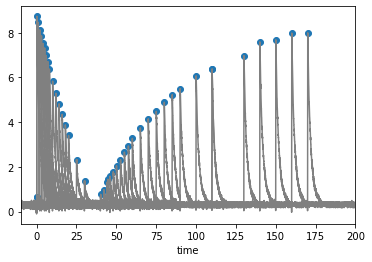

In [105]:
fig,ax = plt.subplots()
# look at index 18, 33/34, 38, 44, they dont match
i = 43
ran = slice(0,44)
for d, P in zip(data[ran], tau[ran]):
    d.plot(x='time', y='signal', ax=ax, label=P, color='gray')
    pass
ax.set_xlim(-10, 200)
#ax.set_ylim(-0,9)

ax.scatter(mtim[ran], msig[ran])
# ax.scatter(tau[ran]*1e-3, msig[ran], marker='x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend().remove()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>